# Example 1: U-Net training

In this example, we build the original U-Net [(Ronneberger et al., 2016)](https://arxiv.org/pdf/1505.04597.pdf) in TensorFlow and train it to segment our platelet data into 7 classes. See (Guay et al., 2019) for more details.

---

## Setup

In [1]:
import logging
import os
import random
import sys
import time

import matplotlib.pyplot as plt
import tensorflow as tf

# Utilities for this example, abstracting away a messy in-lab codebase
from src.demos import demo_data, demo_segmentation
from src.download import download_if_missing
from src.initialize_instance import initialize_instance
from src.create_network import create_network
from src.train_and_eval import train_and_eval
from src.segment import segment

tf.logging.set_verbosity(tf.logging.INFO)
logger_level = logging.INFO

### Data download and example output directories

In [2]:
download_dir = os.path.expanduser('~/examples/unet/data')
output_dir = os.path.expanduser('~/examples/unet/output')

### Download data

If the data already exists in the download folder, the download will be skipped.

In [3]:
download_if_missing(download_dir)

# Dir containing train/eval/test images
data_dir = os.path.join(download_dir, 'platelet_data')

0it [00:00, ?it/s]

100%|█████████▉| 188661760/188671885 [00:13<00:00, 16678806.27it/s]

Extracting /home/matthew/examples/unet/data/platelet_data_1219.zip to /home/matthew/examples/unet/data
Finished


#### Data demo

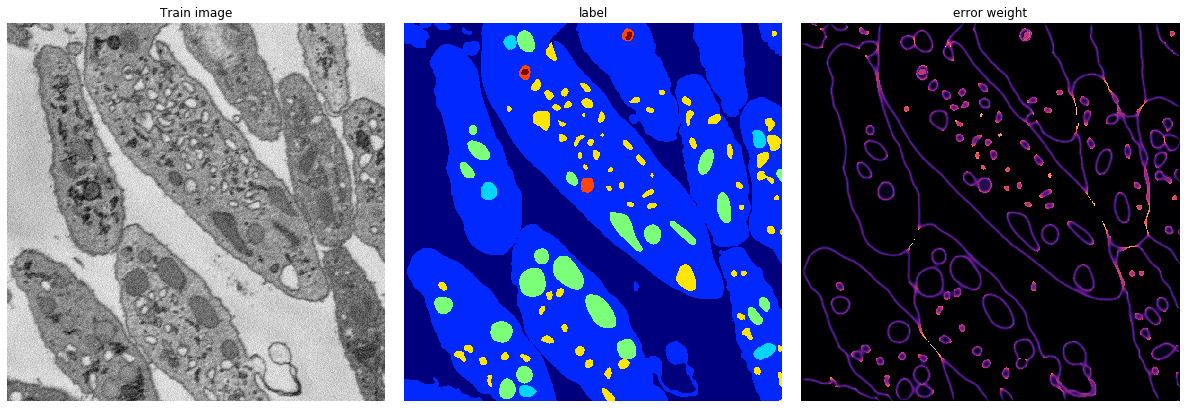

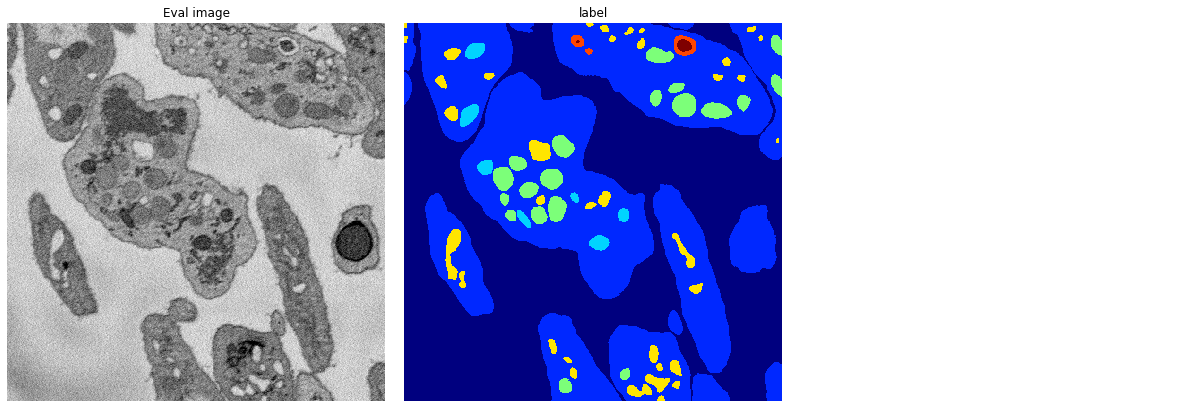

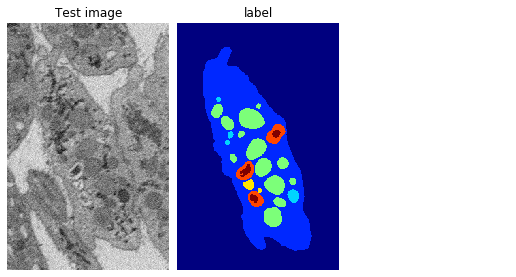

188678144it [00:29, 16678806.27it/s]                               

In [4]:
demo_data(data_dir)

### Training settings

In [5]:
# Original U-Net input size
input_shape = [572, 572]

# Number of training epochs
n_epochs = 20

# Early stopping criterion. Specify a metric ('mean_iou' or 'adj_rand_idx')
# a threshold for the metric, and the epoch to begin testing the criterion
stop_criterion = ('mean_iou', 0.3, 10)

# Save directory for this instance of the example
save_dir = os.path.join(output_dir, time.strftime('%m%d'))

# Trainable weight initialization RNG seed
weight_seed = 12345

# Training data presentation order RNG seed
data_seed = 2468

# 2D training windows are taken from a larger 3D volume, which is
# divided up into overlapping training-window-size regions with
# top-left corners spaced (approximately) this far apart:
train_window_spacing = [1, 80, 80]  # (z, x, y) order

# U-net settings
net_settings = {
    'spatial_mode': 0,          # 2D ops only
    'n_blocks': 4,              # num convolution blocks in the encoder and decoder
    'n_comps': 2,               # num convolutions per block
    'n_kernels': 64,            # num convolution kernels in first encoder block
    'log_gamma2': -5,           # log10 of L2 regularization on weights (ignored if < -10)
    'log_gamma1': -11,          # log10 of L1 regularization on weights (ignored if < -10)
    'padding_type': 'valid',    # Either 'valid' or 'same'. Original U-Net used valid
    'pooling_type': 'maxpool',  # Either 'maxpool' or 'conv'. Original U-Net used maxpool
}

# Optimization settings (ADAM optimizer: https://arxiv.org/pdf/1412.6980.pdf)
optim_settings = {
    'log_learning_rate': -3.3,    # log10 of learning rate
    'log_alpha1': -1.5,           # log10 of alpha1 := 1 - beta1
    'log_alpha2': -2.1,           # log10 of alpha2 := 1 - beta2
    'log_epsilon': -7.,           # log10 of epsilon
    'weight_floor': 0.01,         # minimum weight value for weighted cross-entropy loss
    'exponential_decay_rate': 1,  # exponential decay applied to learning rate
    'log_decay_steps': 10         # log10 of exponential decay step count
}

In [6]:
# Define for saving settings during archival
instance_settings = {
    'data_dir': data_dir,
    'instance_dir': None,  # Defined in `initialize_instance()`
    'input_shape': input_shape,
    'n_epochs': n_epochs,
    'stop_criterion': stop_criterion,
    'weight_seed': weight_seed,
    'data_seed': data_seed,
    'train_window_spacing': train_window_spacing,
    'net_settings': net_settings,
    'optim_settings': optim_settings
}

---

## Network training

### Initialization

Create a folder within `save_dir` for the output of this instance's run, and archive
all example source code. 

In [7]:
# Updates key 'instance_dir' in `instance_settings`, containing the directory within `save_dir`
# where this example instance's output will be saved
instance_settings, logger = initialize_instance(save_dir, instance_settings, logger_level)

### Network creation

Create a network object - a wrapper around a TensorFlow computation graph that
implements training, evaluation, and inference with a U-Net - as well as
settings dicts for the training and evaluation processes.

In [8]:
net, train_settings, eval_settings = create_network(instance_settings)

01/03/2020 05:12:37 - genenet.DataHandler - INFO: Loaded training data from /home/matthew/examples/unet/data/platelet_data
01/03/2020 05:12:37 - genenet.DataHandler - INFO: Loaded eval data from /home/matthew/examples/unet/data/platelet_data


INFO:tensorflow:Using config: {'_model_dir': '/home/matthew/examples/unet/output/0103/0/model', '_tf_random_seed': 12345, '_save_summary_steps': 1000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff238477668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Network training and evaluation

Note: With default settings and an NVIDIA Tesla P100 GPU, this takes about 1.7 hours. 

In [9]:
# Return the trained network
net = train_and_eval(net, train_settings, eval_settings, logger)

01/03/2020 05:12:43 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 1904952089


01/03/2020 05:12:43 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2468


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


Instru



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-01-03T05:19:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-1800
INFO

01/03/2020 05:20:08 - genenet - INFO: Evaluation epoch 0 results:
 {'accuracy': 0.8657113313674927, 'adj_rand_idx': 0.71506667137146, 'loss': 54172.72265625, 'mean_iou': 0.3474779725074768, 'global_step': 1800, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578046802.6732073, 'n_trainable_params': 31030983}
01/03/2020 05:20:08 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 1066694045


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 05:20:26 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2469


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-1800
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1800 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 7196.232, step = 1800
INFO:tensorflow:global_step/sec: 5.55891
INFO:tensorflow:loss =

01/03/2020 05:27:43 - genenet - INFO: Evaluation epoch 1 results:
 {'accuracy': 0.8691043257713318, 'adj_rand_idx': 0.7206096053123474, 'loss': 51353.07421875, 'mean_iou': 0.3603828549385071, 'global_step': 3600, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578047256.9348886, 'n_trainable_params': 31030983}
01/03/2020 05:27:43 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 1660673651


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-3600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 05:28:01 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2470


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-3600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3600 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 6936.288, step = 3600
INFO:tensorflow:global_step/sec: 5.42847
INFO:tensorflow:loss = 8758.596, step = 3700 (18.421 sec)
INFO:tensorflow:global_step/sec: 6

01/03/2020 05:35:32 - genenet - INFO: Evaluation epoch 2 results:
 {'accuracy': 0.9158231019973755, 'adj_rand_idx': 0.7874614000320435, 'loss': 34740.4453125, 'mean_iou': 0.47900277376174927, 'global_step': 5400, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578047717.2042773, 'n_trainable_params': 31030983}
01/03/2020 05:35:32 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 790981822


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-5400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 05:35:51 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2471


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-5400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5400 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 5036.7676, step = 5400
INFO:tensorflow:global_step/sec: 5.40821
INFO:tensorflow:loss = 5411.031, step = 5500 (18.491 sec)
INFO:tensorflow:global_step/sec: 

01/03/2020 05:43:14 - genenet - INFO: Evaluation epoch 3 results:
 {'accuracy': 0.9133481979370117, 'adj_rand_idx': 0.7881381511688232, 'loss': 38185.45703125, 'mean_iou': 0.47999200224876404, 'global_step': 7200, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578048184.125822, 'n_trainable_params': 31030983}
01/03/2020 05:43:14 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 238974813


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-7200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 05:43:33 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2472


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-7200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7200 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 5038.646, step = 7200
INFO:tensorflow:global_step/sec: 5.36091
INFO:tensorflow:loss = 6795.0913, step = 7300 (18.655 sec)
INFO:tensorflow:global_step/sec: 

01/03/2020 05:50:46 - genenet - INFO: Evaluation epoch 4 results:
 {'accuracy': 0.9055404663085938, 'adj_rand_idx': 0.785750687122345, 'loss': 42232.8671875, 'mean_iou': 0.4569730758666992, 'global_step': 9000, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578048643.711757, 'n_trainable_params': 31030983}
01/03/2020 05:50:47 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 216814277


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 05:51:04 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2473


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9000 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 5735.177, step = 9000
INFO:tensorflow:global_step/sec: 5.48325
INFO:tensorflow:loss = 4519.254, step = 9100 (18.239 sec)
INFO:tensorflow:global_step/sec: 6

01/03/2020 05:58:19 - genenet - INFO: Evaluation epoch 5 results:
 {'accuracy': 0.9153659343719482, 'adj_rand_idx': 0.796291708946228, 'loss': 40995.671875, 'mean_iou': 0.4649205803871155, 'global_step': 10800, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578049095.0889282, 'n_trainable_params': 31030983}
01/03/2020 05:58:19 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 643910390


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-10800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 05:58:37 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2474


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-10800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 10800 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 6850.1646, step = 10800
INFO:tensorflow:global_step/sec: 5.24716
INFO:tensorflow:loss = 3075.95, step = 10900 (19.058 sec)
INFO:tensorflow:global_step/se

01/03/2020 06:05:55 - genenet - INFO: Evaluation epoch 6 results:
 {'accuracy': 0.9172882437705994, 'adj_rand_idx': 0.7878344058990479, 'loss': 37206.1015625, 'mean_iou': 0.5063381791114807, 'global_step': 12600, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578049546.916858, 'n_trainable_params': 31030983}
01/03/2020 06:05:55 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 256196228


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-12600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 06:06:14 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2475


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-12600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 12600 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 5618.1704, step = 12600
INFO:tensorflow:global_step/sec: 5.55803
INFO:tensorflow:loss = 5945.2676, step = 12700 (17.992 sec)
INFO:tensorflow:global_step/

01/03/2020 06:13:38 - genenet - INFO: Evaluation epoch 7 results:
 {'accuracy': 0.9243006110191345, 'adj_rand_idx': 0.8066601753234863, 'loss': 35230.70703125, 'mean_iou': 0.5161154866218567, 'global_step': 14400, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578050009.9914355, 'n_trainable_params': 31030983}
01/03/2020 06:13:38 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 236991889


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-14400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 06:13:56 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2476


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-14400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 14400 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 4556.415, step = 14400
INFO:tensorflow:global_step/sec: 5.61879
INFO:tensorflow:loss = 4318.2065, step = 14500 (17.797 sec)
INFO:tensorflow:global_step/s

01/03/2020 06:21:12 - genenet - INFO: Evaluation epoch 8 results:
 {'accuracy': 0.927798330783844, 'adj_rand_idx': 0.8145079016685486, 'loss': 44356.56640625, 'mean_iou': 0.5083082318305969, 'global_step': 16200, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578050466.7917771, 'n_trainable_params': 31030983}
01/03/2020 06:21:12 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 378884944


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-16200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 06:21:32 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2477


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-16200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 16200 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 5516.395, step = 16200
INFO:tensorflow:global_step/sec: 5.36308
INFO:tensorflow:loss = 4217.8687, step = 16300 (18.644 sec)
INFO:tensorflow:global_step/s

01/03/2020 06:28:44 - genenet - INFO: Evaluation epoch 9 results:
 {'accuracy': 0.9277936220169067, 'adj_rand_idx': 0.8163466453552246, 'loss': 38769.40234375, 'mean_iou': 0.4993126094341278, 'global_step': 18000, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578050917.986672, 'n_trainable_params': 31030983}
01/03/2020 06:28:44 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 1666828670


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-18000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 06:29:01 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2478


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-18000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 18000 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 4715.016, step = 18000
INFO:tensorflow:global_step/sec: 5.45031
INFO:tensorflow:loss = 4722.7256, step = 18100 (18.350 sec)
INFO:tensorflow:global_step/s

01/03/2020 06:36:22 - genenet - INFO: Evaluation epoch 10 results:
 {'accuracy': 0.93055659532547, 'adj_rand_idx': 0.8192054629325867, 'loss': 40817.08984375, 'mean_iou': 0.5226422548294067, 'global_step': 19800, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578051369.6443052, 'n_trainable_params': 31030983}
01/03/2020 06:36:22 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 178656871


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-19800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 06:36:43 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2479


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-19800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 19800 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 4565.4663, step = 19800
INFO:tensorflow:global_step/sec: 5.62224
INFO:tensorflow:loss = 3133.2827, step = 19900 (17.786 sec)
INFO:tensorflow:global_step/

01/03/2020 06:43:55 - genenet - INFO: Evaluation epoch 11 results:
 {'accuracy': 0.9289771914482117, 'adj_rand_idx': 0.8194655179977417, 'loss': 45178.72265625, 'mean_iou': 0.49565091729164124, 'global_step': 21600, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578051829.3934712, 'n_trainable_params': 31030983}
01/03/2020 06:43:55 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 130352472


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-21600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 06:44:14 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2480


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-21600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 21600 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 6139.269, step = 21600
INFO:tensorflow:global_step/sec: 5.53845
INFO:tensorflow:loss = 4482.2607, step = 21700 (18.057 sec)
INFO:tensorflow:global_step/s

01/03/2020 06:51:28 - genenet - INFO: Evaluation epoch 12 results:
 {'accuracy': 0.9269894361495972, 'adj_rand_idx': 0.809777021408081, 'loss': 40887.87890625, 'mean_iou': 0.510695219039917, 'global_step': 23400, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578052280.2836127, 'n_trainable_params': 31030983}
01/03/2020 06:51:28 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2019780752


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-23400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 06:51:47 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2481


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-23400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 23400 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 4769.129, step = 23400
INFO:tensorflow:global_step/sec: 5.21907
INFO:tensorflow:loss = 4453.488, step = 23500 (19.158 sec)
INFO:tensorflow:global_step/se

01/03/2020 06:59:00 - genenet - INFO: Evaluation epoch 13 results:
 {'accuracy': 0.9278794527053833, 'adj_rand_idx': 0.8072717189788818, 'loss': 38451.58984375, 'mean_iou': 0.5169186592102051, 'global_step': 25200, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578052735.0843732, 'n_trainable_params': 31030983}
01/03/2020 06:59:00 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 253328218


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-25200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 06:59:19 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2482


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-25200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 25200 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 5175.1787, step = 25200
INFO:tensorflow:global_step/sec: 5.32625
INFO:tensorflow:loss = 3462.805, step = 25300 (18.775 sec)
INFO:tensorflow:global_step/s

01/03/2020 07:06:28 - genenet - INFO: Evaluation epoch 14 results:
 {'accuracy': 0.9290510416030884, 'adj_rand_idx': 0.8119285106658936, 'loss': 43155.05859375, 'mean_iou': 0.5228195786476135, 'global_step': 27000, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578053179.4801276, 'n_trainable_params': 31030983}
01/03/2020 07:06:28 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 1590311964


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-27000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 07:06:46 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2483


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-27000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 27000 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 4755.9634, step = 27000
INFO:tensorflow:global_step/sec: 5.39478
INFO:tensorflow:loss = 3731.7144, step = 27100 (18.535 sec)
INFO:tensorflow:global_step/

01/03/2020 07:14:01 - genenet - INFO: Evaluation epoch 15 results:
 {'accuracy': 0.9292003512382507, 'adj_rand_idx': 0.8150891065597534, 'loss': 42038.15625, 'mean_iou': 0.5126343369483948, 'global_step': 28800, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578053637.0025196, 'n_trainable_params': 31030983}
01/03/2020 07:14:01 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 1287120779


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-28800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 07:14:19 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2484


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-28800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 28800 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 3024.4348, step = 28800
INFO:tensorflow:global_step/sec: 5.48147
INFO:tensorflow:loss = 2199.0444, step = 28900 (18.244 sec)
INFO:tensorflow:global_step/

01/03/2020 07:21:34 - genenet - INFO: Evaluation epoch 16 results:
 {'accuracy': 0.929246723651886, 'adj_rand_idx': 0.8108721375465393, 'loss': 40521.09765625, 'mean_iou': 0.5207335352897644, 'global_step': 30600, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578054089.947238, 'n_trainable_params': 31030983}
01/03/2020 07:21:34 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 1500139473


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-30600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 07:21:52 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2485


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-30600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30600 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 3048.2148, step = 30600
INFO:tensorflow:global_step/sec: 5.48727
INFO:tensorflow:loss = 3365.9138, step = 30700 (18.226 sec)
INFO:tensorflow:global_step/

01/03/2020 07:29:08 - genenet - INFO: Evaluation epoch 17 results:
 {'accuracy': 0.9258917570114136, 'adj_rand_idx': 0.8081552982330322, 'loss': 40522.546875, 'mean_iou': 0.5167825818061829, 'global_step': 32400, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578054544.2787464, 'n_trainable_params': 31030983}
01/03/2020 07:29:08 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 654961297


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-32400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 07:29:27 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2486


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-32400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 32400 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 2705.454, step = 32400
INFO:tensorflow:global_step/sec: 5.32532
INFO:tensorflow:loss = 3235.0159, step = 32500 (18.779 sec)
INFO:tensorflow:global_step/s

01/03/2020 07:36:39 - genenet - INFO: Evaluation epoch 18 results:
 {'accuracy': 0.9324392080307007, 'adj_rand_idx': 0.8212262392044067, 'loss': 42011.09765625, 'mean_iou': 0.530526340007782, 'global_step': 34200, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578054992.0134516, 'n_trainable_params': 31030983}
01/03/2020 07:36:39 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 1439648482


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-34200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 07:36:57 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 2487


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name random_shuffle_queue_DequeueUpTo:1_b0_f0 is illegal; using random_shuffle_queue_DequeueUpTo_1_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-34200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 34200 into /home/matthew/examples/unet/output/0103/0/model/model.ckpt.
INFO:tensorflow:loss = 4191.4204, step = 34200
INFO:tensorflow:global_step/sec: 5.3251
INFO:tensorflow:loss = 4071.9492, step = 34300 (18.778 sec)
INFO:tensorflow:global_step/s

01/03/2020 07:44:17 - genenet - INFO: Evaluation epoch 19 results:
 {'accuracy': 0.9308656454086304, 'adj_rand_idx': 0.8159728646278381, 'loss': 44329.29296875, 'mean_iou': 0.5272819399833679, 'global_step': 36000, 'name': 'U-Net', 'param_seed': 12345, 'last_eval_time': 1578055453.3255336, 'n_trainable_params': 31030983}
01/03/2020 07:44:17 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 834343323


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-36000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


---

## Segmentation with a trained network

#### Using a net to segment an image

In [10]:
# Set to something to save segmentation images to disk there
output_dir = None

test_seg, test_probs = segment(
    net_sources=net,
    image_source=os.path.join(data_dir, 'test-images.tif'),
    label_source=os.path.join(data_dir, 'test-labels.tif'),
    output_dir=output_dir)

01/03/2020 07:44:39 - genenet.DataHandler - INFO: Loaded eval data from /home/matthew/examples/unet/data/platelet_data
01/03/2020 07:44:39 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 601997554


Net input shape: [572, 572]. Net output shape: [388, 388]
[7, 121, 609, 400]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-36000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


#### Visualizing that segmentation

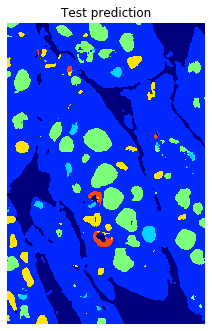

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(400/110, 609/110))

ax.imshow(test_seg[75], cmap='jet', vmin=0, vmax=6)
ax.set_title('Test prediction')
h = ax.axis('off')

#### Demo of network segmentation on train and eval data

Comparisons with ground truth labels, along with visualizations of the inference probability maps for each class

01/03/2020 13:18:50 - genenet.DataHandler - INFO: Loaded eval data from /home/matthew/examples/unet/data/platelet_data
01/03/2020 13:18:50 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 619565160


Net input shape: [572, 572]. Net output shape: [388, 388]
[7, 50, 800, 800]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-36000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


01/03/2020 13:19:24 - genenet.DataHandler - INFO: Loaded eval data from /home/matthew/examples/unet/data/platelet_data
01/03/2020 13:19:24 - genenet.DataHandler - INFO: Seeded DataHandler.random_state with 482580065


Net input shape: [572, 572]. Net output shape: [388, 388]
[7, 24, 800, 800]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name fifo_queue_DequeueUpTo:2_b0_f0 is illegal; using fifo_queue_DequeueUpTo_2_b0_f0 instead.
INFO:tensorflow:Summary name classes/classes:0_b0_f0 is illegal; using classes/classes_0_b0_f0 instead.
INFO:tensorflow:Summary name probabilities/probabilities:0_b0_f0 is illegal; using probabilities/probabilities_0_b0_f0 instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/matthew/examples/unet/output/0103/0/model/model.ckpt-36000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


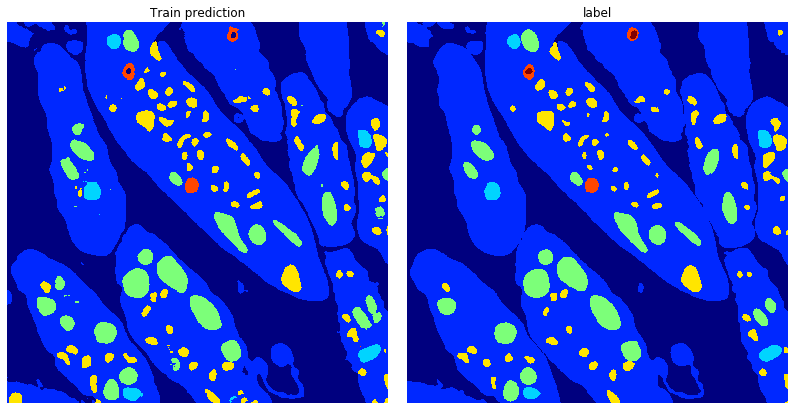

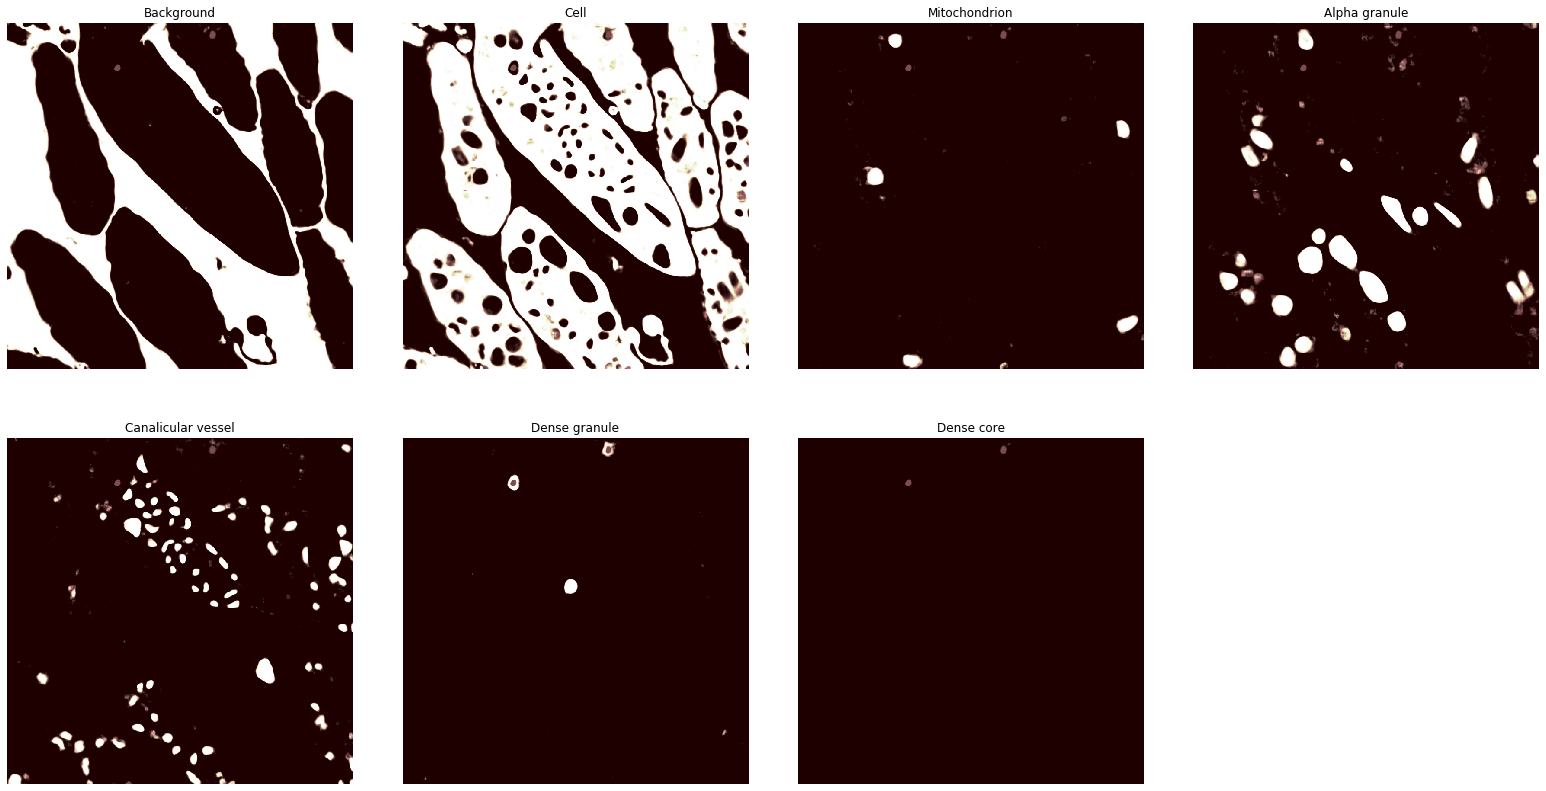

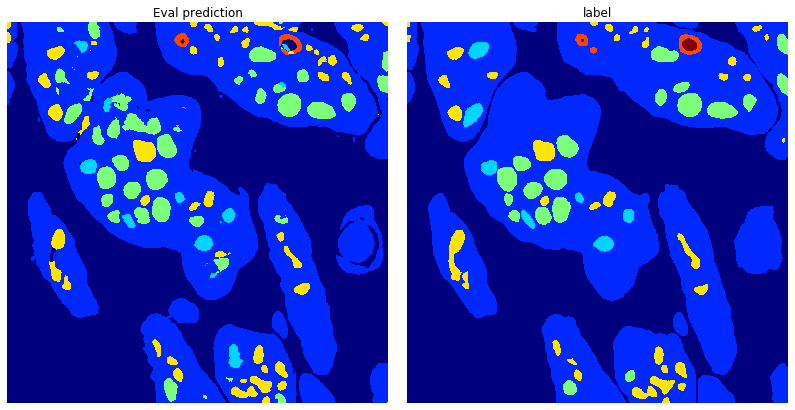

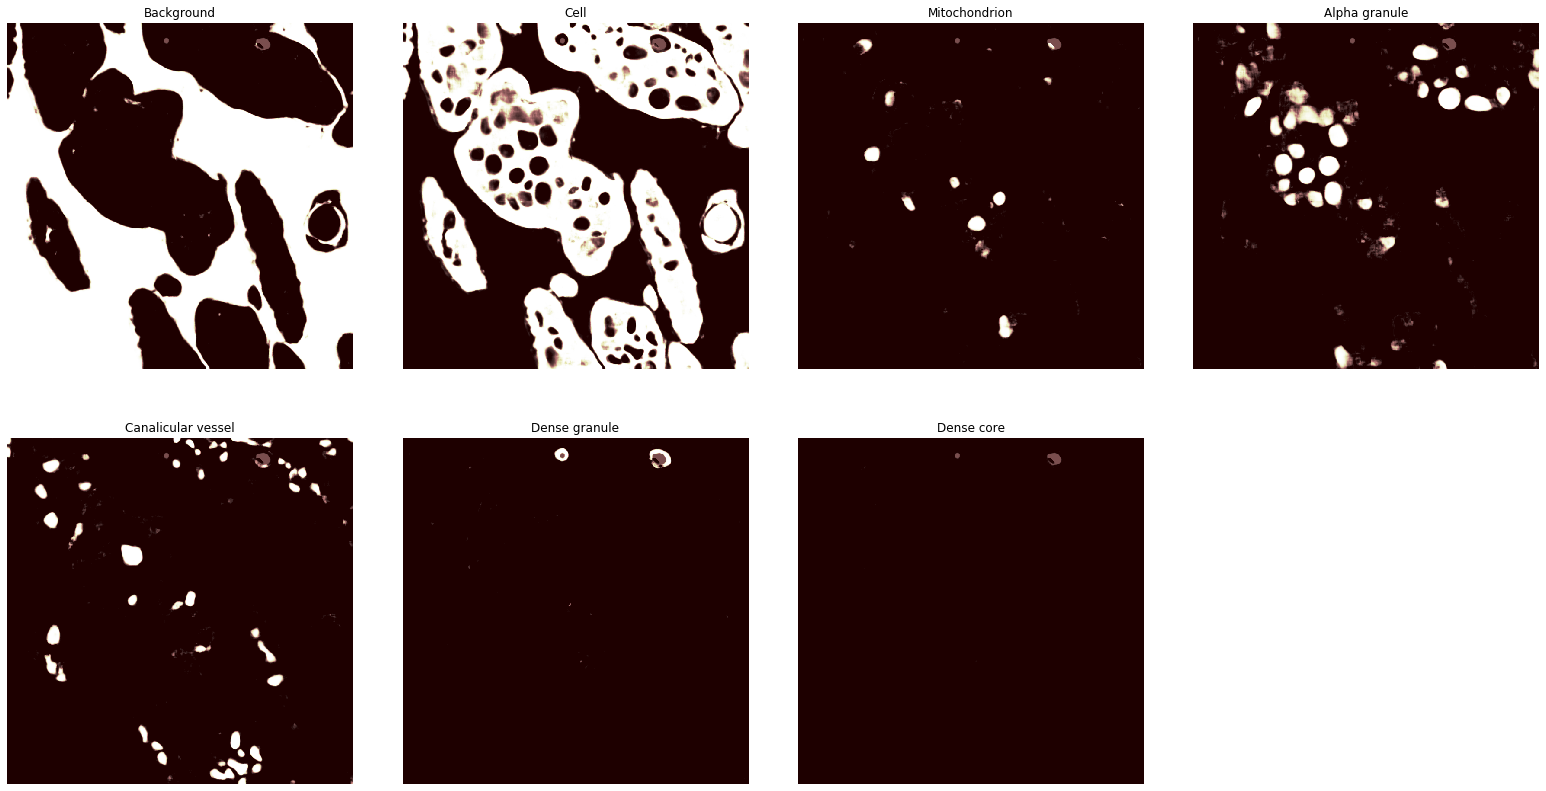

In [13]:
demo_segmentation(net, data_dir)